<a href="https://colab.research.google.com/github/mimijanssen/Allen-Visual-Behavior-Fam-Analysis/blob/main/2023_07_23_load_Allen_Visual_Behavior_from_SDK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This notebook shows how to access and interact with 2-photon calcium imaging data collected as part of the Allen Institute's Visual Behavior 2P project.

You can learn more about this dataset here: <br>[brain-map.org/explore/circuits/visual-behavior-2p](brain-map.org/explore/circuits/visual-behavior-2p) <br>[allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html](allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html)

Specifically, this notebook will show how to load neural data for all imaging planes in one 2-photon imaging session into a single 'tidy' dataframe, make  simple event-triggered plots, and do some basic analysis using scikit-learn.

This is designed to demonstrate a simple method for interacting with the Visual Behavior 2P data. Many aspects of the dataset are not explored here.

# Set up environment and import packages

We have built a package called `brain_observatory_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `brain_observatory_utilities` per the instrutions below.

We will first install `brain_observatory_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues.

You can minimize the cell after you are done to hide the output.

In [1]:
# @title Install packages
!pip install pip --upgrade --quiet
#!pip install brain_observatory_utilities --upgrade --quiet
!pip install git+https://github.com/slinderman/AllenSDK@master
!pip install brain_observatory_utilities --upgrade --quiet
!pip install pandas --quiet
!pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:00
  Cloning https://github.com/slinderman/AllenSDK (to revision master) to /tmp/pip-req-build-a_cq5gkl
  Running command git clone --filter=blob:none --quiet https://github.com/slinderman/AllenSDK /tmp/pip-req-build-a_cq5gkl
  Resolved https://github.com/slinderman/AllenSDK to commit 4a507fec0edd06e0909b4fbc69089e4ac12b8c42
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.5 MB/s eta 0:00:00
  Obtaining dependency information for hdmf from https://files.pythonhosted.org/packages/83/62/d7ddbcfeef29382a4bba97786b4fac8192256d2cc62386568d360dec0920/hdmf-3.8.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.1 MB/s eta 0:00:00
  Obtaining dependency information for scikit-build from https://files.pythonhosted.org/packages/fa/af/b3ef8fe0bb96bf7308e1f9

#### Next we will import packages we need later in the notebook

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [3]:
data_storage_directory = "/temp"  # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 227k/227k [00:00<00:00, 956kMB/s]  
behavior_session_table.csv: 100%|██████████| 1.21M/1.21M [00:00<00:00, 6.47MMB/s]
ophys_experiment_table.csv: 100%|██████████| 610k/610k [00:00<00:00, 3.38MMB/s] 
ophys_cells_table.csv: 100%|██████████| 4.29M/4.29M [00:00<00:00, 10.2MMB/s]


- `Ophys_session_table` contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id.
- `Behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions.
- `Ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the `ophys_container_id` column that can be found in both `ophys_session_table` and `ophys_experiment_table`.

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane.

In [102]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

In [103]:
session_table.head()

equipment_name  \
ophys_session_id                  
951410079                MESO.1   
952430817                MESO.1   
954954402                MESO.1   
955775716                MESO.1   
957020350                MESO.1   

                                                  full_genotype mouse_id  \
ophys_session_id                                                           
951410079         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
952430817         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
954954402         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
955775716         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
957020350         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   

                               reporter_line     driver_line sex  age_in_days  \
ophys_session_id                                                                
951410079         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        206.0   
952430817         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        209.0   
954954402         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        210.0   
955775716         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        212.0   
957020350         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        213.0   

                      cre_line indicator  session_number  \
ophys_session_id                                           
951410079         Sst-IRES-Cre   GCaMP6f             1.0   
952430817         Sst-IRES-Cre   GCaMP6f             2.0   
954954402         Sst-IRES-Cre   GCaMP6f             3.0   
955775716         Sst-IRES-Cre   GCaMP6f             3.0   
957020350         Sst-IRES-Cre   GCaMP6f             4.0   

                  prior_exposures_to_session_type  \
ophys_session_id                                    
951410079                                     0.0   
952430817                                     0.0   
954954402                                     0.0   
955775716                                     1.0   
957020350                                     0.0   

                  prior_exposures_to_image_set  prior_exposures_to_omissions  \
ophys_session_id                                                               
951410079                                 65.0                           0.0   
952430817                                 66.0                           1.0   
954954402                                 67.0                           2.0   
955775716                                 68.0                           3.0   
957020350                                  0.0                           4.0   

                  behavior_session_id  \
ophys_session_id                        
951410079                   951520319   
952430817                   952554548   
954954402                   953982960   
955775716                   956010809   
957020350                   957032492   

                                                ophys_experiment_id  \
ophys_session_id                                                      
951410079         [951980471, 951980473, 951980475, 951980479, 9...   
952430817              [953659743, 953659745, 953659749, 953659752]   
954954402         [958527464, 958527471, 958527474, 958527479, 9...   
955775716                         [956941841, 956941844, 956941846]   
957020350         [957759562, 957759564, 957759566, 957759570, 9...   

                                                 ophys_container_id  \
ophys_session_id                                                      
951410079         [1018028360, 1018028345, 1018028357, 101802834...   
952430817          [1018028357, 1018028345, 1018028339, 1018028354]   
954954402         [1018028360, 1018028342, 1018028357, 101802835...   
955775716                      [1018028342, 1018028339, 1018028345]   
957020350         [1018028354, 1018028345, 1018028360, 101802834...   

                              pr

In [104]:
N1_sess = session_table.loc[session_table['session_type'] == 'OPHYS_4_images_B']
N1_sess = N1_sess.loc[N1_sess['project_code'] == 'VisualBehaviorMultiscope']


In [105]:
N1_sess

equipment_name  \
ophys_session_id                  
957020350                MESO.1   
990139534                MESO.1   
1050597678               MESO.1   
1051319542               MESO.1   
933439847                MESO.1   
1081652280               MESO.1   
1086362421               MESO.1   
1087664594               MESO.1   
883619540                MESO.1   
884613038                MESO.1   
848983781                MESO.1   
882674040                MESO.1   
884451806                MESO.1   
886806800                MESO.1   
888009781                MESO.1   
948042811                MESO.1   
993738515                MESO.1   
993962221                MESO.1   
1077657878               MESO.1   
873247524                MESO.1   
876303107                MESO.1   
1076653403               MESO.1   
1077471417               MESO.1   
973701907                MESO.1   
906521029                MESO.1   
978201478                MESO.1   
920695792                MESO.1   
852794141                MESO.1   
906968227                MESO.1   
913564409                MESO.1   
1084411056               MESO.1   

                                                      full_genotype mouse_id  \
ophys_session_id                                                               
957020350             Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
990139534         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   479839   
1050597678            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   523922   
1051319542            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   523922   
933439847             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   453988   
1081652280            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   546605   
1086362421        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   547486   
1087664594        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   547486   
883619540         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   451787   
884613038         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   451787   
848983781             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   438912   
882674040             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   435431   
884451806             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   435431   
886806800             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   435431   
888009781             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   435431   
948042811             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   453991   
993738515         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   485152   
993962221         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   485152   
1077657878            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   544965   
873247524             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   449653   
876303107             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   449653   
1076653403        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   541329   
1077471417        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   541329   
973701907         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   484627   
906521029         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   456915   
978201478             Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   482853   
920695792             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   453990   
852794141             Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   440631   
906968227         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   453911   
913564409         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   453911   
1084411056        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   547266   

                               reporter_line                      driver_line  \
ophys_session_id                                                                
957020350         Ai148(TIT2L-GC6f-ICL-tTA2)              

In [106]:
len(N1_sess) # 31 sessions

31

In [107]:
N3_sess = session_table.loc[session_table['session_type'] == 'OPHYS_6_images_B']
N3_sess = N3_sess.loc[N3_sess['project_code'] == 'VisualBehaviorMultiscope']

In [108]:
# N3 can be 1-7 prior exposures to the dataset
N3_sess_7 = N3_sess.loc[N3_sess['prior_exposures_to_image_set'] == 7]

In [109]:
len(N3_sess) # 26 sessions

26

In [110]:
N3_sess_7

equipment_name  \
ophys_session_id                  
1056238781               MESO.1   

                                                  full_genotype mouse_id  \
ophys_session_id                                                           
1056238781        Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   528097   

                               reporter_line     driver_line sex  age_in_days  \
ophys_session_id                                                                
1056238781        Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   F        188.0   

                      cre_line indicator  session_number  \
ophys_session_id                                           
1056238781        Vip-IRES-Cre   GCaMP6f             6.0   

                  prior_exposures_to_session_type  \
ophys_session_id                                    
1056238781                                    0.0   

                  prior_exposures_to_image_set  prior_exposures_to_omissions  \
ophys_session_id                                                               
1056238781                                 7.0                          10.0   

                  behavior_session_id                   ophys_experiment_id  \
ophys_session_id                                                              
1056238781                 1056253022  [1057725798, 1057725804, 1057725806]   

                                    ophys_container_id  \
ophys_session_id                                         
1056238781        [1052096566, 1052096554, 1052096570]   

                              project_code        date_of_acquisition  \
ophys_session_id                                                        
1056238781        VisualBehaviorMultiscope 2020-10-13 09:46:25.940282   

                      session_type  
ophys_session_id                    
1056238781        OPHYS_6_images_B

In [63]:
N3_sess #41 sessions

equipment_name  \
ophys_session_id                  
796236521               CAM2P.4   
831761261               CAM2P.4   
832881662               CAM2P.4   
881071629               CAM2P.3   
882620042               CAM2P.3   
880753403               CAM2P.3   
877497698               CAM2P.4   
877907546               CAM2P.4   
943299247               CAM2P.3   
889189329               CAM2P.4   
940447433               CAM2P.5   
855333357               CAM2P.4   
855762043               CAM2P.3   
966603493               CAM2P.5   
1070970140              CAM2P.4   
1071202230              CAM2P.4   
787661032               CAM2P.5   
1052307202              CAM2P.3   
1069224939              CAM2P.3   
976354690               CAM2P.5   
957247123               CAM2P.3   
1054703410              CAM2P.4   
894204946               CAM2P.3   
1008813715              CAM2P.3   
1084241786              CAM2P.3   
893937838               CAM2P.5   
825682144               CAM2P.3   
1044580813              CAM2P.4   
812802821               CAM2P.4   
819949602               CAM2P.5   
845840207               CAM2P.4   
853416014               CAM2P.4   
846599329               CAM2P.3   
835796136               CAM2P.4   
796019065               CAM2P.4   
808092249               CAM2P.5   
809393834               CAM2P.4   
852326785               CAM2P.3   
1085675084              CAM2P.4   
1085943021              CAM2P.4   
952434025               CAM2P.4   

                                                      full_genotype mouse_id  \
ophys_session_id                                                               
796236521             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   412036   
831761261             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   429952   
832881662             Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   429952   
881071629         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...   449441   
882620042         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...   449441   
880753403         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   450471   
877497698         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...   448900   
877907546         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...   448900   
943299247         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   459777   
889189329         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...   456564   
940447433         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   459773   
855333357         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   447663   
855762043         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   445270   
966603493             Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   467302   
1070970140            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   544261   
1071202230            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   544261   
787661032         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   403491   
1052307202            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   533527   
1069224939            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   538219   
976354690         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...   479426   
957247123         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...   457766   
1054703410            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   523927   
894204946         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   456917   
1008813715            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   495789   
1084241786            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   546819   
893937838         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   456916   
825682144         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...   423606   
1044580813            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   524274   
812802821         Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   425493   
819949602         Slc17a7-IRES2

The experiment table has one row per experiment. Note that the `ophys_session_id` column links each experiment to its associated session in the session_table.

In [111]:
experiment_table.head()

equipment_name  \
ophys_experiment_id                  
951980486                   MESO.1   
951980473                   MESO.1   
951980481                   MESO.1   
951980471                   MESO.1   
951980475                   MESO.1   

                                                     full_genotype mouse_id  \
ophys_experiment_id                                                           
951980486            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
951980473            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
951980481            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
951980471            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   
951980475            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   457841   

                                  reporter_line     driver_line sex  \
ophys_experiment_id                                                   
951980486            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
951980473            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
951980481            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
951980471            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
951980475            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   

                     age_in_days      cre_line indicator  session_number  \
ophys_experiment_id                                                        
951980486                  206.0  Sst-IRES-Cre   GCaMP6f             1.0   
951980473                  206.0  Sst-IRES-Cre   GCaMP6f             1.0   
951980481                  206.0  Sst-IRES-Cre   GCaMP6f             1.0   
951980471                  206.0  Sst-IRES-Cre   GCaMP6f             1.0   
951980475                  206.0  Sst-IRES-Cre   GCaMP6f             1.0   

                     prior_exposures_to_session_type  \
ophys_experiment_id                                    
951980486                                        0.0   
951980473                                        0.0   
951980481                                        0.0   
951980471                                        0.0   
951980475                                        0.0   

                     prior_exposures_to_image_set  \
ophys_experiment_id                                 
951980486                                    65.0   
951980473                                    65.0   
951980481                                    65.0   
951980471                                    65.0   
951980475                                    65.0   

                     prior_exposures_to_omissions  ophys_session_id  \
ophys_experiment_id                                                   
951980486                                     0.0         951410079   
951980473                                     0.0         951410079   
951980481                                     0.0         951410079   
951980471                                     0.0         951410079   
951980475                                     0.0         951410079   

                     behavior_session_id  ophys_container_id  \
ophys_experiment_id                                            
951980486                      951520319          1018028360   
951980473                      951520319          1018028345   
951980481                      951520319          1018028357   
951980471                      951520319          1018028342   
951980475                      951520319          1018028339   

                                 project_code  imaging_depth  \
ophys_experiment_id                                            
951980486            VisualBehaviorMultiscope            300   
951980473            VisualBehaviorMultiscope            225   
951980481            VisualBehaviorMultiscope            225   
951980471            VisualBehaviorMultiscope            150   
951980475            VisualBehaviorMultiscope             75   

       

# Load one example session
We are going to select one session from this table, session 854060305. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in Sst+ inhibitory interneurons. There were 6 simultaneously acquired imaging planes for this session.
We can view metadata for this session as follows:

In [16]:
### Sessions Tried ###
# Visual Behavior
# 957020350 (N1) and 959458018 (N3)
# 795625712 (N1) and 796236521 (N3)
# 795625712 (N1) and 1071202230 (N3) -- N1 no VISl , N3 no VISl
# 829521794 (N1) and 825682144 (N3) -- N3 no VISl

# Visual Behavior Multiscope
# 957020350 (N1) and 959458018 (N3)
# 957020350 (N1) and 1056238781 (N3)

In [112]:
ophys_session_id = 957020350
session_table.loc[ophys_session_id]

equipment_name                                                                MESO.1
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                      457841
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                           [Sst-IRES-Cre]
sex                                                                                F
age_in_days                                                                    213.0
cre_line                                                                Sst-IRES-Cre
indicator                                                                    GCaMP6f
session_number                                                                   4.0
prior_exposures_to_session_type                                                  0.0
prior_exposures_to_image_set                                     

In [113]:
ophys_session_id2 = 1056238781 #796236521	 # tried 957020350 (N1) and 959458018 (N3) ;; 795625712 (N1) 796236521 (N3); for multiscope: 957020350 N1, 959458018 N3
session_table.loc[ophys_session_id2]

equipment_name                                                            MESO.1
full_genotype                      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                  528097
reporter_line                                         Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                       [Vip-IRES-Cre]
sex                                                                            F
age_in_days                                                                188.0
cre_line                                                            Vip-IRES-Cre
indicator                                                                GCaMP6f
session_number                                                               6.0
prior_exposures_to_session_type                                              0.0
prior_exposures_to_image_set                                                 7.0
prior_exposures_to_omissions

# Download all associated experiments

Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [114]:
experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespa

In [115]:
experiments2 = {}
ophys_experiment_ids2 = session_table.loc[ophys_session_id2]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids2:
    experiments2[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_1057725798.nwb: 100%|██████████| 240M/240M [00:10<00:00, 22.6MMB/s]
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
behavior_ophys_experiment_1057725804.nwb: 100%|██████████| 234M/234M [00:10<00:00, 21.4MMB/s]
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/pyt

## View the max projection and one cell ROI for one of the experiments
We can view the `cell_specimen_table` for one experiment, which contains information about each identified cell in that experiment

In [116]:
experiment2 = experiments2[ophys_experiment_ids2[0]]
experiment2.cell_specimen_table.head()

cell_roi_id  height  mask_image_plane  max_correction_down  \
cell_specimen_id                                                               
1086608979         1080635528      16                 0                  5.0   
1086609031         1080635530      14                 0                  5.0   
1086609294         1080635531      14                 0                  5.0   
1086609112         1080635532      14                 0                  5.0   
1086609716         1080635533      13                 0                  5.0   

                  max_correction_left  max_correction_right  \
cell_specimen_id                                              
1086608979                       28.0                  23.0   
1086609031                       28.0                  23.0   
1086609294                       28.0                  23.0   
1086609112                       28.0                  23.0   
1086609716                       28.0                  23.0   

                  max_correction_up  valid_roi  width    x    y  \
cell_specimen_id                                                  
1086608979                     29.0       True     13  336   46   
1086609031                     29.0       True     13  463  284   
1086609294                     29.0       True     15  237  278   
1086609112                     29.0       True     14  367  243   
1086609716                     29.0       True     13  399  326   

                                                           roi_mask  
cell_specimen_id                                                     
1086608979        [[False, False, False, False, False, False, Fa...  
1086609031        [[False, False, False, False, False, False, Fa...  
1086609294        [[False, False, False, False, False, False, Fa...  
1086609112        [[False, False, False, False, False, False, Fa...  
1086609716        [[False, False, False, False, False, False, Fa...

In [117]:
experiment = experiments[ophys_experiment_ids[0]]
experiment.cell_specimen_table.head()

cell_roi_id  height  mask_image_plane  max_correction_down  \
cell_specimen_id                                                               
1086614149         1080740882      16                 0                  5.0   
1086614819         1080740886      22                 0                  5.0   
1086614512         1080740888      19                 0                  5.0   
1086613265         1080740947      20                 0                  5.0   
1086616398         1080740952      20                 0                  5.0   

                  max_correction_left  max_correction_right  \
cell_specimen_id                                              
1086614149                       25.0                   3.0   
1086614819                       25.0                   3.0   
1086614512                       25.0                   3.0   
1086613265                       25.0                   3.0   
1086616398                       25.0                   3.0   

                  max_correction_up  valid_roi  width    x    y  \
cell_specimen_id                                                  
1086614149                     30.0       True     17  216  456   
1086614819                     30.0       True     16  443  275   
1086614512                     30.0       True     22  248  294   
1086613265                     30.0       True     21  305  183   
1086616398                     30.0       True     19  220  161   

                                                           roi_mask  
cell_specimen_id                                                     
1086614149        [[False, False, False, False, False, False, Fa...  
1086614819        [[False, False, False, False, False, False, Fa...  
1086614512        [[False, False, False, False, False, False, Fa...  
1086613265        [[False, False, False, False, False, False, Fa...  
1086616398        [[False, False, False, False, False, False, Fa...

We can then visualize the max projection and one of the identified ROIs

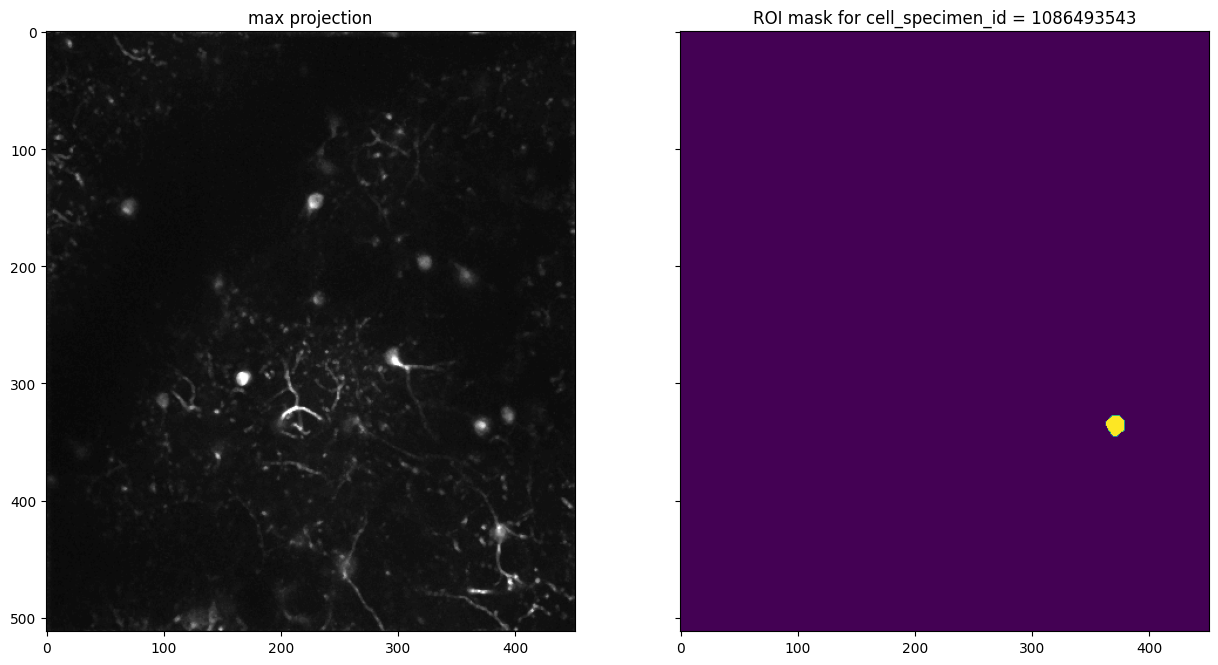

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
ax[0].imshow(experiment.max_projection, cmap='gray')
ax[0].set_title('max projection')

cell_specimen_id = experiment.cell_specimen_table.index[2]
ax[1].imshow(experiment.cell_specimen_table.loc[cell_specimen_id]['roi_mask'])
ax[1].set_title('ROI mask for cell_specimen_id = {}'.format(cell_specimen_id))
fig.show()

## Load neural data into memory


The cell below will load the neural data into memory in the pandas 'tidy' format by iterating over each of the 6 experiments and using some helpful tools from the `brain_observatory_utilities` package that was imported above as `ophys`.

It will also include a subset of metadata from `ophys_experiment_table` to facilitate splitting by depth, structure (aka cortical area), cre line (aka cell class), etc.

Note that 'tidy' data means that each row represents only one observation. Observations are stacked vertically. Thus, the `timestamps` colums will repeat for every cell in the dataset.

In [118]:
neural_data_N3 = []
for ophys_experiment_id in tqdm(experiments2.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments2[ophys_experiment_id]
    this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_experiment)

    # add some columns with metadata for the experiment
    metadata_keys = [
      'ophys_experiment_id',
      'ophys_session_id',
      'targeted_structure',
      'imaging_depth',
      'equipment_name',
      'cre_line',
      'mouse_id',
      'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]

    # append the data for this experiment to a list
    neural_data_N3.append(this_experiment_neural_data)

# concatate the list of dataframes into a single dataframe
neural_data_N3 = pd.concat(neural_data_N3)

100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


In [119]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_experiment)

    # add some columns with metadata for the experiment
    metadata_keys = [
      'ophys_experiment_id',
      'ophys_session_id',
      'targeted_structure',
      'imaging_depth',
      'equipment_name',
      'cre_line',
      'mouse_id',
      'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]

    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)

# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


We can then look at some attributes of the `neural_data` dataframe we have created.

It is ~2.5 million rows long:

In [120]:
len(neural_data)

3766152

In [121]:
len(neural_data_N3)

1069718

It is so long because has one row for each timestamp for each cell.

Below are the first 5 entries. Again, note that the `tidy` format means that each row has only one observation, which represents a single GCaMP6 fluorescnce value for a single neuron.

In [122]:
neural_data_N3.head()

timestamps       dff    events  filtered_events  cell_roi_id  \
0     9.13079  1.459096  0.000000     0.000000e+00   1080635528   
1     9.24026  1.801153  0.565887     4.602187e-01   1080635528   
2     9.34974  1.561436  0.000000     1.044467e-01   1080635528   
3     9.45921  1.313316  0.000000     1.220918e-03   1080635528   
4     9.56868  1.248984  0.000000     7.350879e-07   1080635528   

   cell_specimen_id  ophys_experiment_id  ophys_session_id targeted_structure  \
0        1086608979           1057725798        1056238781               VISp   
1        1086608979           1057725798        1056238781               VISp   
2        1086608979           1057725798        1056238781               VISp   
3        1086608979           1057725798        1056238781               VISp   
4        1086608979           1057725798        1056238781               VISp   

  imaging_depth equipment_name      cre_line mouse_id sex  
0          None         MESO.1  Vip-IRES-Cre   528097   F  
1          None         MESO.1  Vip-IRES-Cre   528097   F  
2          None         MESO.1  Vip-IRES-Cre   528097   F  
3          None         MESO.1  Vip-IRES-Cre   528097   F  
4          None         MESO.1  Vip-IRES-Cre   528097   F

In [123]:
# only take VISl data
neural_data = neural_data.loc[neural_data['targeted_structure'] == 'VISl']

In [124]:
neural_data_N3 = neural_data_N3.loc[neural_data_N3['targeted_structure'] == 'VISl']

In [126]:
neural_data_N3.head()

timestamps       dff    events  filtered_events  cell_roi_id  \
0     9.18553  1.371812  0.000000     0.000000e+00   1080634803   
1     9.29500  1.782836  0.683042     5.554973e-01   1080634803   
2     9.40447  1.505981  0.000000     1.260702e-01   1080634803   
3     9.51395  1.583595  0.000000     1.473683e-03   1080634803   
4     9.62342  1.503360  0.000000     8.872724e-07   1080634803   

   cell_specimen_id  ophys_experiment_id  ophys_session_id targeted_structure  \
0        1086609690           1057725804        1056238781               VISl   
1        1086609690           1057725804        1056238781               VISl   
2        1086609690           1057725804        1056238781               VISl   
3        1086609690           1057725804        1056238781               VISl   
4        1086609690           1057725804        1056238781               VISl   

  imaging_depth equipment_name      cre_line mouse_id sex  
0          None         MESO.1  Vip-IRES-Cre   528097   F  
1          None         MESO.1  Vip-IRES-Cre   528097   F  
2          None         MESO.1  Vip-IRES-Cre   528097   F  
3          None         MESO.1  Vip-IRES-Cre   528097   F  
4          None         MESO.1  Vip-IRES-Cre   528097   F

In [125]:
neural_data.head()

timestamps       dff  events  filtered_events  cell_roi_id  \
0     8.77128  0.291522     0.0              0.0   1080722688   
1     8.86448  0.434159     0.0              0.0   1080722688   
2     8.95768  0.502652     0.0              0.0   1080722688   
3     9.05088  0.355607     0.0              0.0   1080722688   
4     9.14408  0.211703     0.0              0.0   1080722688   

   cell_specimen_id  ophys_experiment_id  ophys_session_id targeted_structure  \
0        1086607071            957759570         957020350               VISl   
1        1086607071            957759570         957020350               VISl   
2        1086607071            957759570         957020350               VISl   
3        1086607071            957759570         957020350               VISl   
4        1086607071            957759570         957020350               VISl   

  imaging_depth equipment_name      cre_line mouse_id sex  
0          None         MESO.1  Sst-IRES-Cre   457841   F  
1          None         MESO.1  Sst-IRES-Cre   457841   F  
2          None         MESO.1  Sst-IRES-Cre   457841   F  
3          None         MESO.1  Sst-IRES-Cre   457841   F  
4          None         MESO.1  Sst-IRES-Cre   457841   F

- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions.
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id.

# Examine Cell IDs
We can get the unique Cell IDs in our dataset as follows:

In [127]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 46 unique cells
cell ids are: [1086607071 1086607143 1086607340 1086607562 1086608432 1086610383
 1086607814 1086608913 1086608195 1086607431 1086607903 1086609334
 1086606974 1086607195 1086608294 1086610611 1086608811 1086608379
 1086610696 1086608491 1086609380 1086608577 1086608630 1086618338
 1086617208 1086617703 1086617474 1086620047 1086620729 1086619247
 1086619132 1086611981 1086610246 1086611638 1086610123 1086609699
 1086609798 1086609503 1086610759 1086609100 1086612438 1086612827
 1086611670 1086611915 1086611955 1086611645]


In [128]:
cell_ids2 = neural_data_N3['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids2)))
print('cell ids are: {}'.format(cell_ids2))

there are 16 unique cells
cell ids are: [1086609690 1086610142 1086609789 1086609639 1086609989 1086610075
 1086607394 1086606909 1086607055 1086607477 1086606824 1086607234
 1086607009 1086607103 1086607139 1086607443]


If we wanted to get the timeseries for one cell, we could query the `neural_data` dataframe. For example, to get the full timeseries for the cell with `cell_specimen_id = 1086557208`:

In [129]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086607071')
single_cell_timeseries.head(20)

timestamps       dff  events  filtered_events  cell_roi_id  \
0      8.77128  0.291522     0.0              0.0   1080722688   
1      8.86448  0.434159     0.0              0.0   1080722688   
2      8.95768  0.502652     0.0              0.0   1080722688   
3      9.05088  0.355607     0.0              0.0   1080722688   
4      9.14408  0.211703     0.0              0.0   1080722688   
5      9.23729  0.283293     0.0              0.0   1080722688   
6      9.33049 -0.221997     0.0              0.0   1080722688   
7      9.42369  0.108841     0.0              0.0   1080722688   
8      9.51689  0.536951     0.0              0.0   1080722688   
9      9.61009 -0.285647     0.0              0.0   1080722688   
10     9.70329  0.067208     0.0              0.0   1080722688   
11     9.79649  0.014048     0.0              0.0   1080722688   
12     9.88969 -0.035669     0.0              0.0   1080722688   
13     9.98289 -0.069525     0.0              0.0   1080722688   
14    10.07609  0.061475     0.0              0.0   1080722688   
15    10.16929 -0.069246     0.0              0.0   1080722688   
16    10.26249 -0.249424     0.0              0.0   1080722688   
17    10.35569 -0.194241     0.0              0.0   1080722688   
18    10.44889  0.294759     0.0              0.0   1080722688   
19    10.54209 -0.010759     0.0              0.0   1080722688   

    cell_specimen_id  ophys_experiment_id  ophys_session_id  \
0         1086607071            957759570         957020350   
1         1086607071            957759570         957020350   
2         1086607071            957759570         957020350   
3         1086607071            957759570         957020350   
4         1086607071            957759570         957020350   
5         1086607071            957759570         957020350   
6         1086607071            957759570         957020350   
7         1086607071            957759570         957020350   
8         1086607071            957759570         957020350   
9         1086607071            957759570         957020350   
10        1086607071            957759570         957020350   
11        1086607071            957759570         957020350   
12        1086607071            957759570         957020350   
13        1086607071            957759570         957020350   
14        1086607071            957759570         957020350   
15        1086607071            957759570         957020350   
16        1086607071            957759570         957020350   
17        1086607071            957759570         957020350   
18        1086607071            957759570         957020350   
19        1086607071            957759570         957020350   

   targeted_structure imaging_depth equipment_name      cre_line mouse_id sex  
0                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
1                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
2                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
3                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
4                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
5                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
6                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
7                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
8                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
9                VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
10               VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
11               VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
12               VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
13               VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
14               VISl          None         MESO.1  Sst-IRES-Cre   457841   F  
15           

Each cell has three types of traces:
- `dff` column is the Calcium fluorescence signal, normalized to background fluorescence.
- `events` column is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in [Visual Behavior whitepaper](https://portal.brain-map.org/explore/circuits/visual-behavior-2p)).
- `filtered_events` column is events smoothed with a half-gaussian kernel.

We can then plot DeltaF/F for this cell for the full experiment as follows:

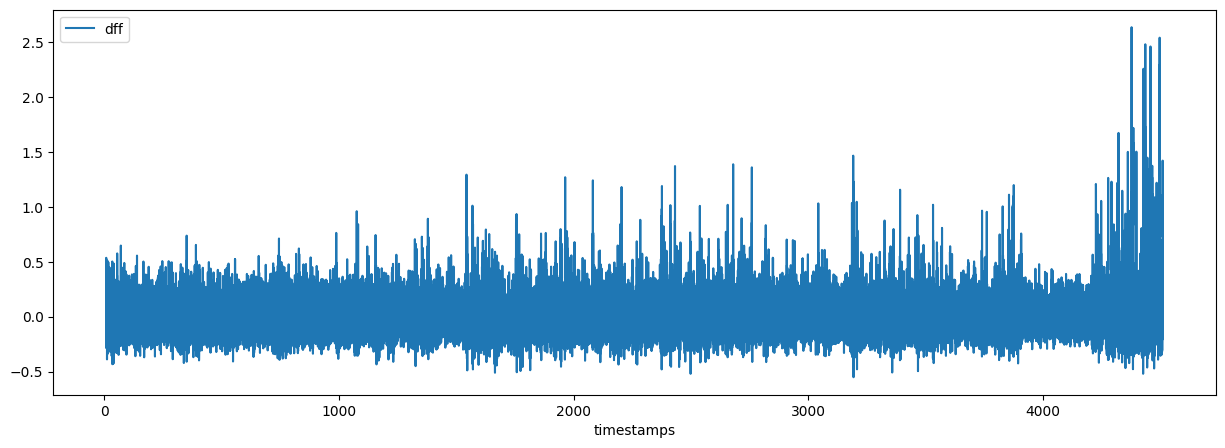

In [130]:
fig, ax = plt.subplots(figsize=(15,5))
single_cell_timeseries.plot(
    x = 'timestamps',
    y = 'dff',
    ax = ax
)
fig.show()

# Load stimulus data into memory
The stimulus table is shared across all experiments (imaging planes) in a session. We can therefore use the stimulus table for just one experiment.

We are going to drop the `image_set` column because it is not informative for our purposes. We can then view the first 10 rows of the stimulus table.

In [131]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
stimulus_table.head(10)

duration  end_frame  flashes_since_change  \
stimulus_presentations_id                                              
0                           0.25020    18001.0                   0.0   
1                           0.25020    18046.0                   1.0   
2                           0.25017    18091.0                   2.0   
3                           0.25026    18136.0                   3.0   
4                           0.25020    18181.0                   4.0   
5                           0.25021    18226.0                   5.0   
6                           0.25022    18271.0                   6.0   
7                           0.25020    18316.0                   0.0   
8                           0.25020    18361.0                   1.0   
9                           0.25019    18406.0                   2.0   

                           image_index image_name  is_change  omitted  \
stimulus_presentations_id                                               
0                                    0      im000      False    False   
1                                    0      im000      False    False   
2                                    0      im000      False    False   
3                                    0      im000      False    False   
4                                    0      im000      False    False   
5                                    0      im000      False    False   
6                                    0      im000      False    False   
7                                    6      im031       True    False   
8                                    6      im031      False    False   
9                                    6      im031      False    False   

                           start_frame  start_time   end_time  
stimulus_presentations_id                                      
0                                17986   308.75313  309.00333  
1                                18031   309.50374  309.75394  
2                                18076   310.25441  310.50458  
3                                18121   311.00496  311.25522  
4                                18166   311.75558  312.00578  
5                                18211   312.50620  312.75641  
6                                18256   313.25681  313.50703  
7                                18301   314.00741  314.25761  
8                                18346   314.75803  315.00823  
9                                18391   315.50864  315.75883

In [202]:
stimulus_table2 = experiments2[ophys_experiment_ids2[0]].stimulus_presentations
stimulus_table2.head(10)

duration  end_frame  flashes_since_change  \
stimulus_presentations_id                                              
0                           0.25018    18001.0                   0.0   
1                           0.25020    18046.0                   1.0   
2                           0.25019    18091.0                   2.0   
3                           0.25021    18136.0                   3.0   
4                           0.25020    18181.0                   4.0   
5                           0.25022    18226.0                   5.0   
6                           0.25022    18271.0                   6.0   
7                           0.25022    18316.0                   7.0   
8                           0.25020    18361.0                   8.0   
9                           0.25021    18406.0                   9.0   

                           image_index image_name  is_change  omitted  \
stimulus_presentations_id                                               
0                                    0      im000      False    False   
1                                    0      im000      False    False   
2                                    0      im000      False    False   
3                                    0      im000      False    False   
4                                    0      im000      False    False   
5                                    0      im000      False    False   
6                                    0      im000      False    False   
7                                    0      im000      False    False   
8                                    0      im000      False    False   
9                                    0      im000      False    False   

                           start_frame  start_time   end_time  
stimulus_presentations_id                                      
0                                17986   309.15922  309.40940  
1                                18031   309.90984  310.16004  
2                                18076   310.66043  310.91062  
3                                18121   311.41103  311.66124  
4                                18166   312.16165  312.41185  
5                                18211   312.91226  313.16248  
6                                18256   313.66289  313.91311  
7                                18301   314.41350  314.66372  
8                                18346   315.16412  315.41432  
9                                18391   315.91473  316.16494

## View the `stimulus_templates` attribute
Note that the `unwarped` column contains the image before the application of a spherical warp. All of the pixels labeled 'NaN' will be off-screen (not visible to the mouse) after the warp is applied.

All experiments in a given session will share the same `stimulus_templates`

In [132]:
experiment = experiments[ophys_experiment_ids[0]]
experiment.stimulus_templates

unwarped  \
image_name                                                      
im000       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im106       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im075       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im073       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im045       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im054       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im031       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im035       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                       warped  
image_name                                                     
im000       [[122, 122, 123, 125, 126, 127, 128, 129, 130,...  
im106       [[108, 109, 106, 103, 102, 104, 107, 112, 117,...  
im075       [[120, 121, 121, 121, 122, 123, 123, 122, 121,...  
im073       [[120, 120, 118, 116, 116, 119, 121, 120, 117,...  
im045       [[10, 13, 6, 0, 0, 8, 15, 13, 6, 2, 4, 9, 12, ...  
im054       [[124, 125, 127, 130, 133, 134, 136, 138, 140,...  
im031       [[233, 234, 244, 253, 253, 244, 237, 239, 246,...  
im035       [[178, 181, 189, 198, 200, 198, 196, 199, 205,...

In [203]:
experiment2 = experiments2[ophys_experiment_ids2[0]]
experiment2.stimulus_templates

unwarped  \
image_name                                                      
im000       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im106       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im075       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im073       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im045       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im054       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im031       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im035       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                       warped  
image_name                                                     
im000       [[122, 122, 123, 125, 126, 127, 128, 129, 130,...  
im106       [[108, 109, 106, 103, 102, 104, 107, 112, 117,...  
im075       [[120, 121, 121, 121, 122, 123, 123, 122, 121,...  
im073       [[120, 120, 118, 116, 116, 119, 121, 120, 117,...  
im045       [[10, 13, 6, 0, 0, 8, 15, 13, 6, 2, 4, 9, 12, ...  
im054       [[124, 125, 127, 130, 133, 134, 136, 138, 140,...  
im031       [[233, 234, 244, 253, 253, 244, 237, 239, 246,...  
im035       [[178, 181, 189, 198, 200, 198, 196, 199, 205,...

## View the unwarped images

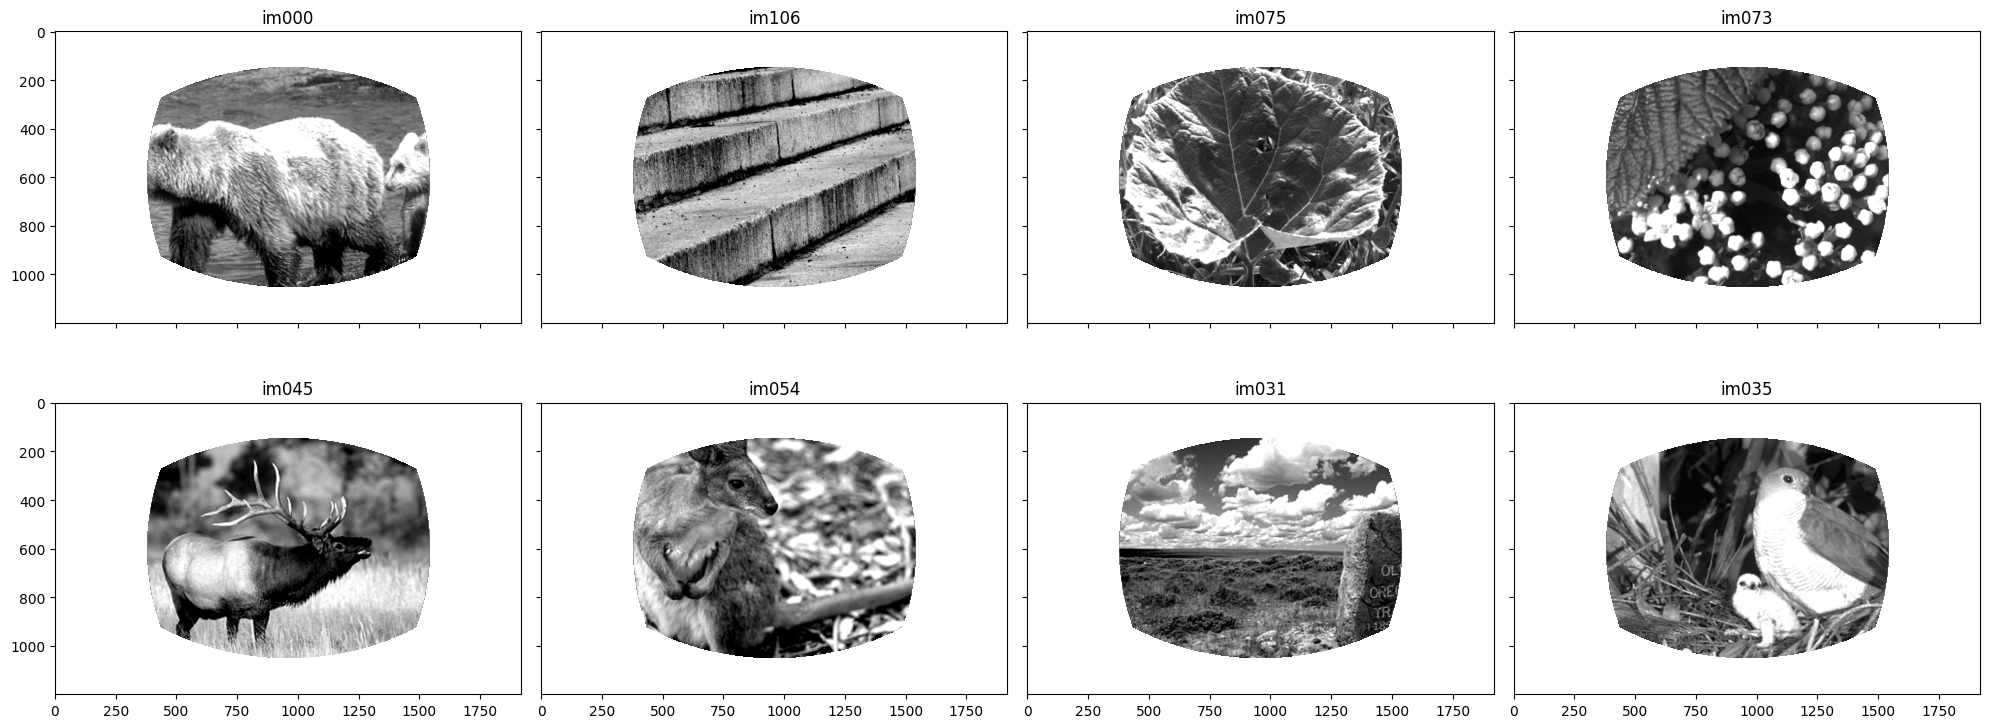

In [133]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for ii, image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()
fig.show()

## View the warped images
This represents what was actually on the screen during the session

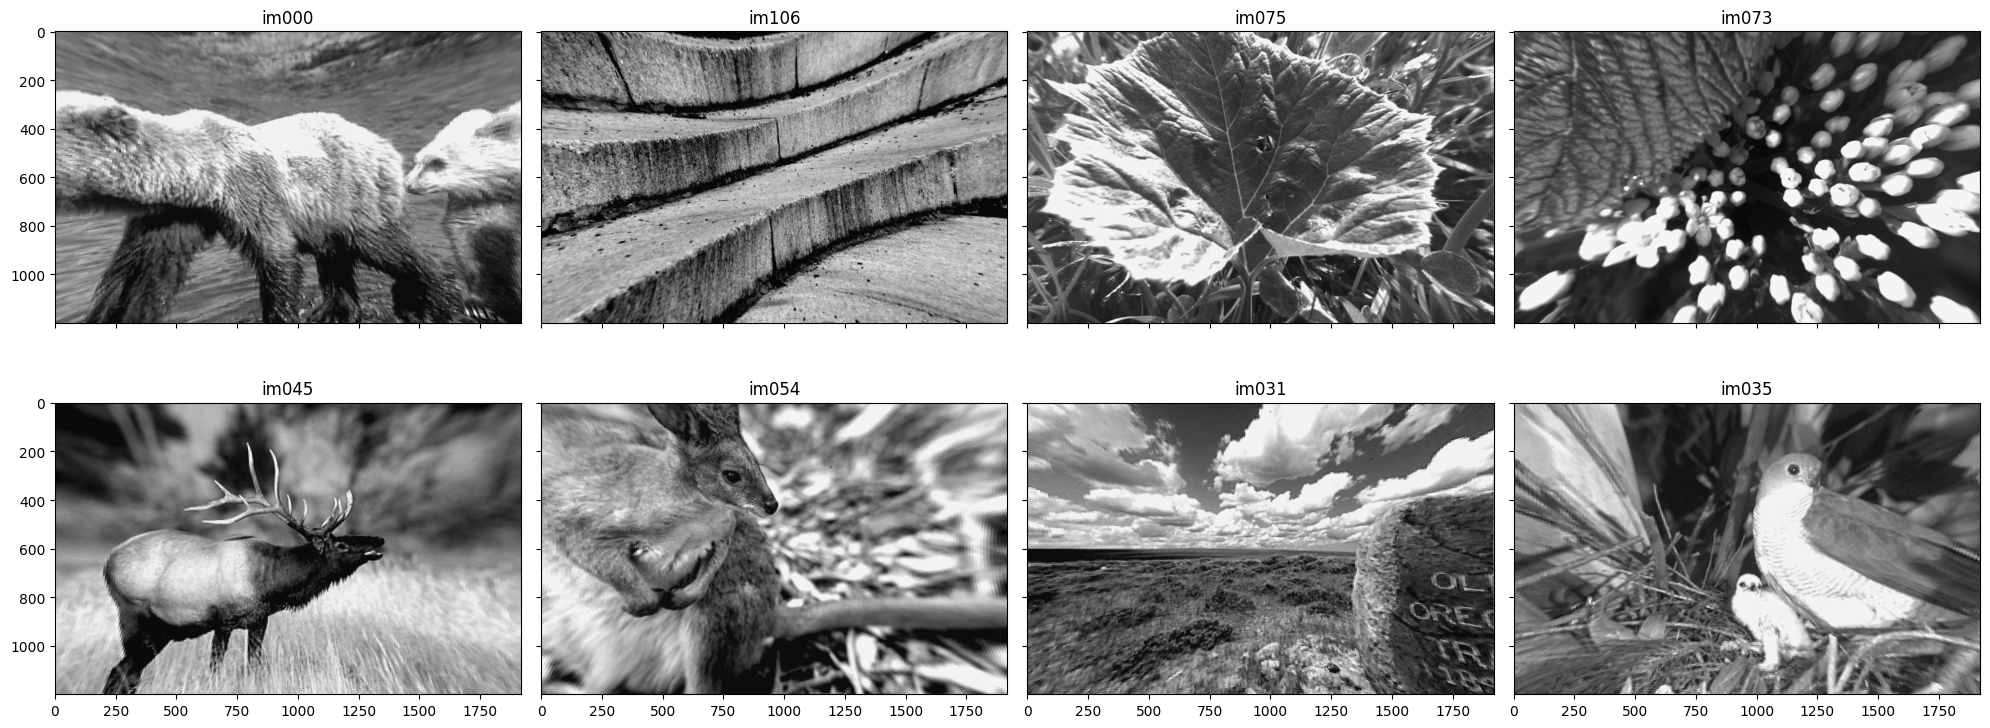

In [134]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for ii, image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['warped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()
fig.show()

## Describe stimulus omissions
An important feature of the task is that stimuli are shown at a very regular cadence (250 ms on, 500 ms off), but stimuli are randomly omitted with a probability of ~5%. These unexpected and random stimulus omissions could be perceived as an expectation violation by the mouse.

Omitted stimuli are denoted in the `stimulus_table` by the `omitted` column. `True` means that the stimulus that would have been shown at that time was actually omitted (and was replaced by an extended gray screen between stimuli).

We can look at the first 10 examples of omitted stimuli as follows. Note that each 'omitted' stimulus still has a 'start_time' and a 'stop_time' associated with it. This actually represents the time that a stimulus would have been shown, had it not been omitted.

Stimulus omissions are also indicated in the `image_name` column by the string `omitted`

In [37]:
stimulus_table.query('is_change').head(10) #changed from omitted to is_change

duration  end_frame  flashes_since_change  \
stimulus_presentations_id                                              
7                           0.25020    18316.0                   0.0   
24                          0.25020    19081.0                   0.0   
64                          0.25022    20881.0                   0.0   
109                         0.25021    22907.0                   0.0   
158                         0.25026    25112.0                   0.0   
276                         0.25015    30421.0                   0.0   
317                         0.25017    32266.0                   0.0   
332                         0.25016    32942.0                   0.0   
429                         0.25021    37309.0                   0.0   
518                         0.25018    41315.0                   0.0   

                           image_index image_name  is_change  omitted  \
stimulus_presentations_id                                               
7                                    6      im031       True    False   
24                                   0      im000       True    False   
64                                   5      im054       True    False   
109                                  0      im000       True    False   
158                                  3      im073       True    False   
276                                  1      im106       True    False   
317                                  3      im073       True    False   
332                                  2      im075       True    False   
429                                  3      im073       True    False   
518                                  4      im045       True    False   

                           start_frame  start_time   end_time  
stimulus_presentations_id                                      
7                                18301   314.00741  314.25761  
24                               19066   326.76785  327.01805  
64                               20866   356.79237  357.04259  
109                              22892   390.58665  390.83686  
158                              25097   427.36670  427.61696  
276                              30406   515.92247  516.17262  
317                              32251   546.69756  546.94773  
332                              32927   557.97345  558.22361  
429                              37294   630.81626  631.06647  
518                              41300   697.63754  697.88772

In [164]:
fam_score_sess.head(10)

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
5    6.0
6    7.0
7    0.0
8    0.0
9    0.0
dtype: float64

In [169]:
### we want to know how many times the stimulus is shown to the animal. In a specific epoch and also how many times it is shown within the set. ###
count_list = np.zeros(len(stimulus_table['image_index'].unique())) # the number of different images
count_list_sess = np.zeros(len(stimulus_table['image_index'].unique())) # the number of different images

fam_score = pd.Series(np.zeros(len(stimulus_table))); # initializes length  of fam score
fam_score_sess = pd.Series(np.zeros(len(stimulus_table))); # initializes length  of fam score
count_list[stimulus_table['image_index'][0]] += 1 ;

# add counter to all current images up until the first image change ...
index0 = np.where(stimulus_table['is_change'])[0]  # gets index of all changes in array form
fam0 = stimulus_table.iloc[index0]['image_index'] # array of image_index presentations
ind = index0[0];
fam_score_sess[0:fam0.index[0]] = np.array(range(1,stimulus_table.index[ind+1]));

# add counter to current image (average_responses['image_index'][0])
index0 = np.where(stimulus_table['is_change'])[0]  # gets index of all changes in array form
fam0 = stimulus_table.iloc[index0]['image_index'] # array of image_index presentations
fam_score[0:fam0.index[0]] = 1;

def handleOneRow(average_responses):
  index = np.where(stimulus_table['is_change'])[0]  # gets index of all changes in array form
  index0 = np.where(stimulus_table['is_change'])[0]  # gets index of all changes in array form
  fam = stimulus_table.iloc[index]['image_index'] # array of image_index presentations
  fam0 = stimulus_table.iloc[index0]['image_index'] # array of image_index presentations
  for count,val in enumerate(fam): # for each image_index in the array, add that to the counter
    count_list[fam.iloc[count]] += 1;  # updates counter
    ind = index0[count];
    if count < len(fam)-1:
      fam_score[fam.index[count]:fam.index[count+1]] = (count_list[fam.iloc[count]]) # add counter value to the dataframe column
      array_length = fam.index[count+1] - fam.index[count] ;
      fam_score_sess[fam.index[count]:fam.index[count+1]] = np.array(range(1, array_length+1))# this needs to be the next image index stimulus_table.index[ind+1]));
  return fam_score, fam_score_sess

In [170]:
fam_score, fam2 = handleOneRow(stimulus_table)

In [204]:
fam_score_N3, fam2_N3 = handleOneRow(stimulus_table2)

In [172]:
fam = fam_score.to_frame(name='fam_score')
fam_sess = fam_score_sess.to_frame(name='fam_score_sess')

In [205]:
fam_N3 = fam_score_N3.to_frame(name='fam_score')
fam_sess_N3 = fam2_N3.to_frame(name='fam_score_sess')

In [173]:
stimulus_table = pd.concat([stimulus_table, fam_score.to_frame(name='fam_score')], axis =1)
stimulus_table = pd.concat([stimulus_table, fam_score_sess.to_frame(name='fam_score_sess')], axis =1)

In [207]:
stimulus_table2 = pd.concat([stimulus_table2, fam_score_N3.to_frame(name='fam_score')], axis =1)
stimulus_table2 = pd.concat([stimulus_table2, fam2_N3.to_frame(name='fam_score_sess')], axis =1)

In [174]:
stimulus_table.head(30) # fam score is the number of sets is shown , fam_score_sess is the number of times within a block that the image is presented

duration  end_frame  flashes_since_change  image_index image_name  \
0    0.25020    18001.0                   0.0            0      im000   
1    0.25020    18046.0                   1.0            0      im000   
2    0.25017    18091.0                   2.0            0      im000   
3    0.25026    18136.0                   3.0            0      im000   
4    0.25020    18181.0                   4.0            0      im000   
5    0.25021    18226.0                   5.0            0      im000   
6    0.25022    18271.0                   6.0            0      im000   
7    0.25020    18316.0                   0.0            6      im031   
8    0.25020    18361.0                   1.0            6      im031   
9    0.25019    18406.0                   2.0            6      im031   
10   0.25000        NaN                   2.0            8    omitted   
11   0.25022    18496.0                   3.0            6      im031   
12   0.25021    18541.0                   4.0            6      im031   
13   0.25021    18586.0                   5.0            6      im031   
14   0.25020    18631.0                   6.0            6      im031   
15   0.25020    18676.0                   7.0            6      im031   
16   0.25021    18721.0                   8.0            6      im031   
17   0.25019    18766.0                   9.0            6      im031   
18   0.25021    18811.0                  10.0            6      im031   
19   0.25020    18856.0                  11.0            6      im031   
20   0.26690    18901.0                  12.0            6      im031   
21   0.25021    18946.0                  13.0            6      im031   
22   0.25021    18991.0                  14.0            6      im031   
23   0.25021    19036.0                  15.0            6      im031   
24   0.25020    19081.0                   0.0            0      im000   
25   0.25020    19126.0                   1.0            0      im000   
26   0.25020    19171.0                   2.0            0      im000   
27   0.25021    19216.0                   3.0            0      im000   
28   0.25020    19261.0                   4.0            0      im000   
29   0.25020    19306.0                   5.0            0      im000   

    is_change  omitted  start_frame  start_time   end_time  fam_score  \
0       False    False        17986   308.75313  309.00333        1.0   
1       False    False        18031   309.50374  309.75394        1.0   
2       False    False        18076   310.25441  310.50458        1.0   
3       False    False        18121   311.00496  311.25522        1.0   
4       False    False        18166   311.75558  312.00578        1.0   
5       False    False        18211   312.50620  312.75641        1.0   
6       False    False        18256   313.25681  313.50703        1.0   
7        True    False        18301   314.00741  314.25761        1.0   
8       False    False        18346   314.75803  315.00823        1.0   
9       False    False        18391   315.50864  315.75883        1.0   
10      False     True        18435   316.24258  316.49258        1.0   
11      False    False        18481   317.00986  317.26008        1.0   
12      False    False        18526   317.76048  318.01069        1.0   
13      False    False        18571   318.51110  318.76131        1.0   
14      False    False        18616   319.26173  319.51193        1.0   
15      False    False        18661   320.01233  320.26253        1.0   
16      False    False        18706   320.76293  321.01314        1.0   
17      False    False        18751   321.51355  321.76374        1.0   
18      False    False        18796   322.26415  322.51436        1.0   
19      False    False        18841   323.01482  323.26502        1.0   
20      False    False        18885   323.74870  324.01560        1.0   
21      False    False        18931   324.51601  324.76622        1.0   
22      False    False        18976   325.26662  325.51683   

In [208]:
stimulus_table2['fam_score_sess'].unique() # sometimes shown 148 times :O

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148.,   0.,  nan])

# Create an event triggered response dataframe relative to omissions
If we want to see how a given cell responds when regularly flashed stimuli are omitted, we can calculate the response around each of the stimulus omissions. The `brain_observatory_utilities` package has a convenience function to do this, in the module we imported as `utilities`. We give the function:
* a dataframe of interest (containing activity from one cell)
* the t and y values of interest
* the event times
* how much time before and after each event we are interested in
* the desired sampling rate of the output - this is the rate onto which the response will be interpolated

The function will return a new dataframe with the response for the given cell, aligned to each of the events.

In [135]:
### EVENT TRIGGERED RESPONSE RELATIVE TO IMAGE CHANGE ###
cell_id = cell_ids[11]
etr = utilities.event_triggered_response(
    data=neural_data.query('cell_specimen_id == @cell_id'),
    t='timestamps',
    y='dff',
    event_times=stimulus_table.query('is_change')['start_time'], #changed from omitted to is_change
    t_before=1,
    t_after=1,
    output_sampling_rate=50,
)
etr

time       dff  event_number  stimulus_presentations_id  event_time
0     -1.00 -0.070916             0                          7   314.00741
1     -0.98 -0.070916             0                          7   314.00741
2     -0.96 -0.070916             0                          7   314.00741
3     -0.94 -0.076086             0                          7   314.00741
4     -0.92 -0.081305             0                          7   314.00741
...     ...       ...           ...                        ...         ...
25952  0.92  0.369375           256                       4791  3905.52511
25953  0.94  0.369375           256                       4791  3905.52511
25954  0.96  0.369375           256                       4791  3905.52511
25955  0.98  0.369375           256                       4791  3905.52511
25956  1.00  0.369375           256                       4791  3905.52511

[25957 rows x 5 columns]

In [210]:
### EVENT TRIGGERED RESPONSE RELATIVE TO IMAGE CHANGE ###
cell_id = cell_ids2[11]
etr = utilities.event_triggered_response(
    data=neural_data_N3.query('cell_specimen_id == @cell_id'),
    t='timestamps',
    y='dff',
    event_times=stimulus_table2.query('is_change')['start_time'], #changed from omitted to is_change
    t_before=1,
    t_after=1,
    output_sampling_rate=50,
)
etr

time       dff  event_number  original_index  event_time
0     -1.00  0.177107             0              44   342.18621
1     -0.98  0.177107             0              44   342.18621
2     -0.96  0.177107             0              44   342.18621
3     -0.94  0.177107             0              44   342.18621
4     -0.92  0.177107             0              44   342.18621
...     ...       ...           ...             ...         ...
19993  0.92 -0.112711           197            4796  3909.60084
19994  0.94 -0.112711           197            4796  3909.60084
19995  0.96 -0.112711           197            4796  3909.60084
19996  0.98 -0.112711           197            4796  3909.60084
19997  1.00 -0.112711           197            4796  3909.60084

[19998 rows x 5 columns]

We can see that the output has colums for
* `time` - this is our new timebase relative to the events. In this case, it ranges from -3 to 3
* `dff` - this is the deltaF/F value surrounding each event, interpolated onto the new timebase. If, when calling the `event_triggered_response` function we had passed `y = 'events'`, this column would be events instead of dff.
* `event_number` - this is an integer representing the count of each event. In this example, there were 185 omissions, so they are numbered from 0 to 184
* `event_time` - this is the time of each event



The docstring for the `event_triggered_response` function can be viewed as follows:

In [136]:
help(utilities.event_triggered_response)

Help on function event_triggered_response in module brain_observatory_utilities.utilities.general_utilities:

event_triggered_response(data, t, y, event_times, t_start=None, t_end=None, t_before=None, t_after=None, output_sampling_rate=None, include_endpoint=True, output_format='tidy', interpolate=True)
    Slices a timeseries relative to a given set of event times
    to build an event-triggered response.
    
    For example, If we have data such as a measurement of neural activity
    over time and specific events in time that we want to align
    the neural activity to, this function will extract segments of the neural
    timeseries in a specified time window around each event.
    
    The times of the events need not align with the measured
    times of the neural data.
    Relative times will be calculated by linear interpolation.
    
    Parameters:
    -----------
    data: Pandas.DataFrame
        Input dataframe in tidy format
        Each row should be one observation
   

## Plot an event triggered response

The output format of the `event_triggered_response` function is designed to plug directly into Seaborn's `lineplot` plotting function. We can then view the mean response to omitted stimuli with 95% confidence intervals very easily:

<Axes: xlabel='time', ylabel='dff'>

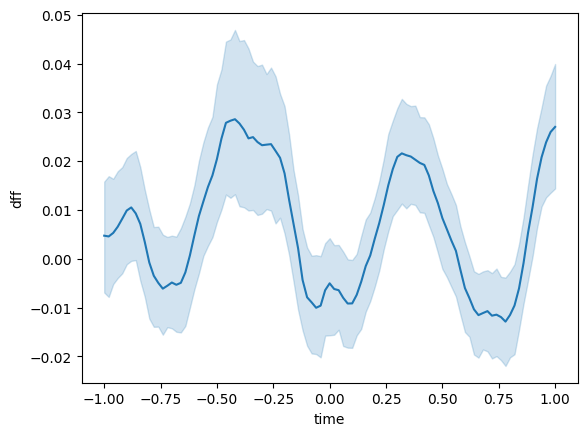

In [137]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

Note that the regular, image-driven responses with a 750 ms inter-stimulus interval are visible everywhere except at t=0, which is when the unexpectedly omitted stimulus occured.

### Make a function to plot an event triggered average in one line

If we make a wrapper function that combines the process of calculating and plotting the event triggered response, it can be called in a single line below. By having `event_query` input variable, we can use this function to plot responses to any event of interest (omisisons, changes, hits/misses, specific images, etc)

In [190]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=0.750, t_after=0.750):
    etr = utilities.event_triggered_response(
      data=df,
      t='timestamps',
      y=y,
      event_times=stimulus_table.query(event_query)['start_time'],
      t_before=t_before,
      t_after=t_before,
      output_sampling_rate=50,
      )
    sns.lineplot(
      data=etr,
      x=x,
      y=y,
      n_boot=500,
      ax=ax
      )

Now plot the omission triggered response for the same cell using filtered events (these events extracted from the deltaF/F timeseries using an event extraction algorithm, then smoothed with a half-gaussian kernel) instead of dff.

In [ ]:
timestamps = sst_data.trace_timestamps.values[0]
for exposure_level in sst_data.exposure_level.unique():
  traces = sst_data[sst_data.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('SST population average')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

<ipython-input-201-477a23ddbfc4>:39: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7d1b6fbd2740> starts with '_'. It is thus excluded from the legend.
  ax.legend(['exposure 1', '_', 'exposure 2', '_', 'exposure 3','_','exposure 4','_','exposure 5'])
<ipython-input-201-477a23ddbfc4>:39: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7d1b6f0dc280> starts with '_'. It is thus excluded from the legend.
  ax.legend(['exposure 1', '_', 'exposure 2', '_', 'exposure 3','_','exposure 4','_','exposure 5'])
<ipython-input-201-477a23ddbfc4>:39: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7d1b7a293a00> starts with '_'. It is thus excluded from the legend.
  ax.legend(['exposure 1', '_', 'exposure 2', '_', 'exposure 3','_','exposure 4','_','exposure 5'])
<ipython-input-201-477a23ddbfc4>:39: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7d1b7a42e5c0> starts wit

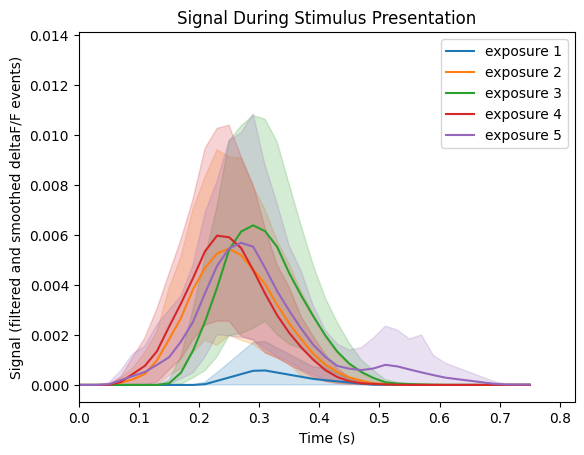

In [201]:
### FOR N1 ###
cell_id = cell_ids[11]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df=neural_data.query('cell_specimen_id == @cell_id'),
    x='time',
    y='filtered_events',
    event_query='fam_score_sess == 1',
    ax=ax
)
make_event_triggered_plot(
    df=neural_data.query('cell_specimen_id == @cell_id'),
    x = 'time',
    y = 'filtered_events',
    event_query='fam_score_sess == 2',
    ax=ax
)
make_event_triggered_plot(
    df=neural_data.query('cell_specimen_id == @cell_id'),
    x = 'time',
    y = 'filtered_events',
    event_query='fam_score_sess == 3',
    ax=ax
)
make_event_triggered_plot(
    df=neural_data.query('cell_specimen_id == @cell_id'),
    x = 'time',
    y = 'filtered_events',
    event_query='fam_score_sess == 4',
    ax=ax
)
make_event_triggered_plot(
    df=neural_data.query('cell_specimen_id == @cell_id'),
    x = 'time',
    y = 'filtered_events',
    event_query='fam_score_sess == 5',
    ax=ax
)

ax.legend(['exposure 1', '_', 'exposure 2', '_', 'exposure 3','_','exposure 4','_','exposure 5'])
plt.xlim(left=0)  # adjust the right leaving left unchanged
plt.title('Signal During Stimulus Presentation')
plt.xlabel('Time (s)'),
plt.ylabel('Signal (filtered and smoothed deltaF/F events)'),
fig.show()

<ipython-input-211-7e21f2128327>:40: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7d1b7a5f6890> starts with '_'. It is thus excluded from the legend.
  ax.legend(['exposure 1', '_', 'exposure 2', '_', 'exposure 3','_','exposure 4','_','exposure 5'])
<ipython-input-211-7e21f2128327>:40: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7d1b6f0c3220> starts with '_'. It is thus excluded from the legend.
  ax.legend(['exposure 1', '_', 'exposure 2', '_', 'exposure 3','_','exposure 4','_','exposure 5'])
<ipython-input-211-7e21f2128327>:40: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7d1b7a2c3cd0> starts with '_'. It is thus excluded from the legend.
  ax.legend(['exposure 1', '_', 'exposure 2', '_', 'exposure 3','_','exposure 4','_','exposure 5'])
<ipython-input-211-7e21f2128327>:40: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7d1b7a2c3eb0> starts wit

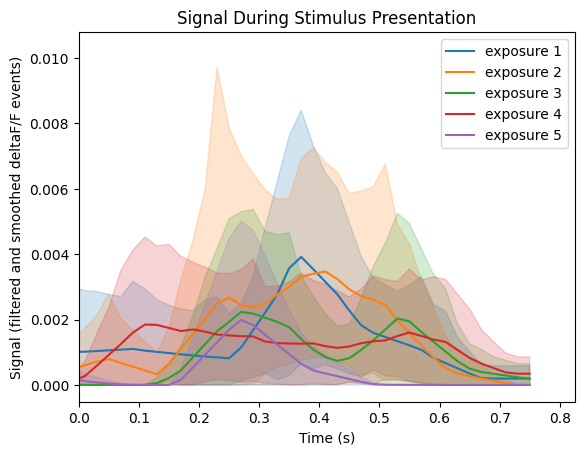

In [211]:
### FOR N3 ###
cell_id = cell_ids2[11]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df=neural_data_N3.query('cell_specimen_id == @cell_id'),
    x='time',
    y='filtered_events',
    event_query='fam_score_sess == 1',
    ax=ax
)
make_event_triggered_plot(
    df=neural_data_N3.query('cell_specimen_id == @cell_id'),
    x = 'time',
    y = 'filtered_events',
    event_query='fam_score_sess == 2',
    ax=ax
)
make_event_triggered_plot(
    df=neural_data_N3.query('cell_specimen_id == @cell_id'),
    x = 'time',
    y = 'filtered_events',
    event_query='fam_score_sess == 3',
    ax=ax
)
make_event_triggered_plot(
    df=neural_data_N3.query('cell_specimen_id == @cell_id'),
    x = 'time',
    y = 'filtered_events',
    event_query='fam_score_sess == 4',
    ax=ax
)
make_event_triggered_plot(
    df=neural_data_N3.query('cell_specimen_id == @cell_id'),
    x = 'time',
    y = 'filtered_events',
    event_query='fam_score_sess == 5',
    ax=ax
)

ax.legend(['exposure 1', '_', 'exposure 2', '_', 'exposure 3','_','exposure 4','_','exposure 5'])
plt.xlim(left=0)  # adjust the right leaving left unchanged
plt.title('Signal During Stimulus Presentation')
plt.xlabel('Time (s)'),
plt.ylabel('Signal (filtered and smoothed deltaF/F events)'),
fig.show()

## Plot the responses for 10 sample cells
We can then iterate over 10 randomly chosen cells and plot their activity during omissions.

100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


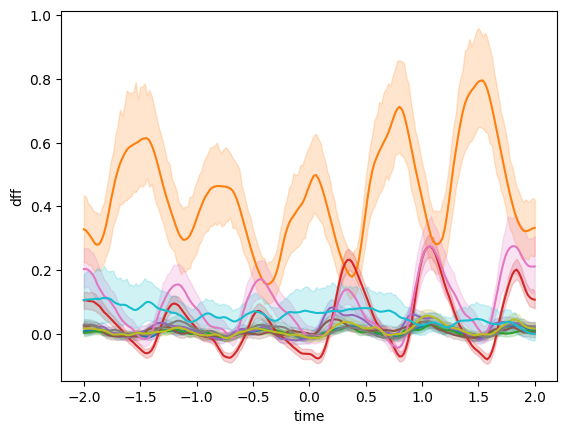

In [43]:
np.random.seed(0)
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    make_event_triggered_plot(
      df=neural_data.query('cell_specimen_id == @cell_id'),
      x='time',
      y='dff',
      event_query='is_change',
      ax=ax
      )
fig.show()

Interestingly, not all SST cells in this session do the same thing!

## Calculate the mean response for each of the individual imaging planes in this experiment
By iterating over experiment IDs, we can also calculate the mean response for each of the 6 imaging planes. Do Sst cells in different visual areas respond to omissions in a distinct way?

We will first use a Pandas `groupby` and `mean` operations to get the mean timeseries for each cell in that imaging plane:

In [44]:
mean_dff_by_experiment = (
    neural_data
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
    )

In [45]:
mean_dff_by_experiment

ophys_experiment_id  timestamps       dff
0                 957759570     8.77128  1.346234
1                 957759570     8.86448  1.311395
2                 957759570     8.95768  1.038471
3                 957759570     9.05088  0.817893
4                 957759570     9.14408  0.521945
...                     ...         ...       ...
193131            957759576  4509.86435  2.610776
193132            957759576  4509.95758  2.654295
193133            957759576  4510.05081  2.383841
193134            957759576  4510.14405  2.175829
193135            957759576  4510.23728  2.232614

[193136 rows x 3 columns]

We can then iterate over our 6 experiment IDs and use our `make_event_triggered_plot` wrapper function to calculate and plot the omission triggered response for that imaging plane:

  0%|          | 0/7 [00:00<?, ?it/s]


ValueError: ignored

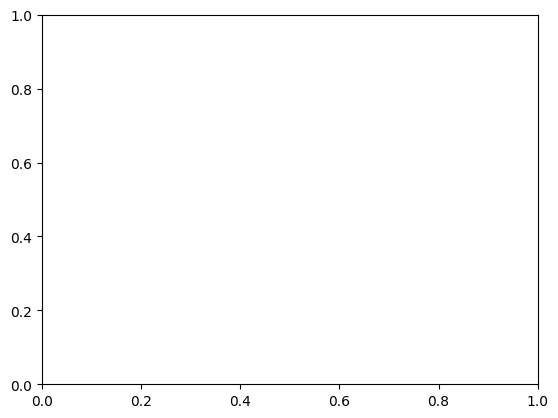

In [47]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(ophys_experiment_ids):
    make_event_triggered_plot(
      df=mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'),
      x='time',
      y='dff',
      event_query='is_change',
      ax=ax
      )

    # get some metadata to add to the legend
    this_exp = neural_data_N3.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]
    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))

# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))
fig.show()

  0%|          | 0/7 [00:00<?, ?it/s]


ValueError: ignored

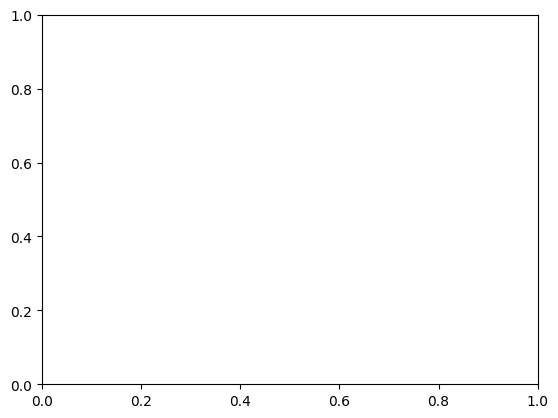

In [48]:
### RUNNING THIS I RAN OUT OF RAM ###
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(ophys_experiment_ids):
    make_event_triggered_plot(
      df=mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'),
      x='time',
      y='dff',
      event_query='is_change',
      ax=ax
      )

    # get some metadata to add to the legend
    this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]
    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))

# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))
fig.show()

  0%|          | 0/7 [00:00<?, ?it/s]


ValueError: ignored

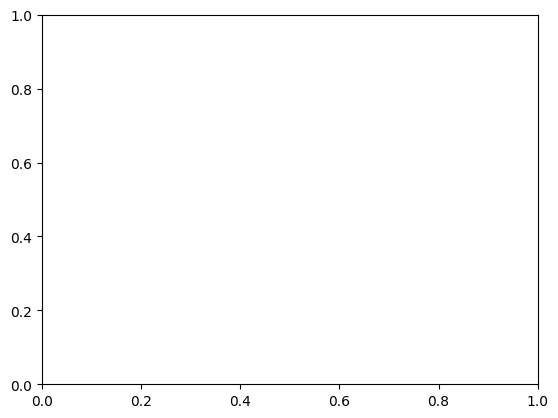

In [57]:
### EVENT TRIGER PLOT TO CHANGE IN IMAGE ###
###############added#######################
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(ophys_experiment_ids):
     make_event_triggered_plot(
      df=mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'),
      x='time',
      y='dff',
      event_query='is_change',
      ax=ax
      )

    # get some metadata to add to the legend
     this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
     structure = this_exp['targeted_structure'].iloc[0]
     depth = this_exp['imaging_depth'].iloc[0]
    # append a string to our list of legend text
     legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))

# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))
fig.show()

There are clearly some large differences in the way that Sst cells respond to these unexpected stimulus omissions by area.

This example could be extended to include cells from the other two cre-lines in the dataset: The VIP-Cre line which labels VIP+ inhibitory interneurons and the Slc17a7 line, which is a pan-excitatory line.

In [ ]:
session_table['cre_line'].unique()

array(['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre'], dtype=object)

In addition, responses to different stimuli could be explored, along with responses relative to other behavioral measures, such as licking.

For a full description of the dataset and all available data streams, see the Visual Behavior Project Description at:
https://portal.brain-map.org/explore/circuits/visual-behavior-2p

# Set up data for scikit learn
What if we wanted to use scikit-learn for a decoding or clustering analysis? We'd need to get the data into a standard format for scikit learn, which is often a feature matrix (`X`) and a vector of labels (`y`).

Instead of just omissions, let's now look at the responses to each of the stimuli in this session, which consists of 8 unique images, plus the omitted stimuli (which we characterize as a unique stimulus type). First, we will calculate an event triggered response to each stimulus start time in the stimulus table.

In [52]:
full_etr_l = []
# iterate over each unique cell
for cell_specimen_id in tqdm(neural_data['cell_specimen_id'].unique()):
  # calculate the event triggered response for this cell to every stimulus
  full_etr_this_cell = utilities.event_triggered_response(
      neural_data.query('cell_specimen_id == @cell_specimen_id'),
      t='timestamps',
      y='dff',
      event_times=stimulus_table['start_time'],
      t_before=0,
      t_after=0.75,
      output_sampling_rate=30
  )
  # add a column identifying the cell_specimen_id
  full_etr_this_cell['cell_specimen_id'] = cell_specimen_id
  # append to our list
  full_etr_l.append(full_etr_this_cell)

# concatenate our list of dataframes into a single dataframe
full_etr = pd.concat(full_etr_l)

# cast these numeric columns to int and float, respectively
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)

# rename 'event_number' as
# full_etr.rename(columns={'event_number': 'stimulus_presentations_id'}, inplace=True)

100%|██████████| 46/46 [01:39<00:00,  2.17s/it]


One way to construct a feature matrix might be to build it such that dimensions are `trials x cells`. Thus:

* Each row would be one trial, where a trial is defined as a unique image presentation
* Each column would represent the average response of a given cell on that image presentation.

To do so, let's construct another intermediate dataframe called `average_responses` that contains the average response of each cell (in the 750 ms window we've selected above) to each image presentation. We'll do this using a Pandas groupby to group by `cell_specimen_id` and `stimulus_presentations_id` (aka trial).

We're also going to merge in our stimulus metadata.

In [54]:
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)

In [55]:
average_responses = full_etr.groupby(['cell_specimen_id', 'stimulus_presentations_id'])[['dff']].mean().reset_index().merge(
    stimulus_table,
    on='stimulus_presentations_id',
    how='left'
)
average_responses.head(37)

cell_specimen_id  stimulus_presentations_id       dff  duration  \
0         1086606974                          0  0.816926   0.25020   
1         1086606974                          1  0.998366   0.25020   
2         1086606974                          2  1.287106   0.25017   
3         1086606974                          3  1.921719   0.25026   
4         1086606974                          4  1.450025   0.25020   
5         1086606974                          5  0.578358   0.25021   
6         1086606974                          6  0.870997   0.25022   
7         1086606974                          7  1.911224   0.25020   
8         1086606974                          8  1.411322   0.25020   
9         1086606974                          9  0.222781   0.25019   
10        1086606974                         10 -0.109117   0.25000   
11        1086606974                         11  1.219535   0.25022   
12        1086606974                         12  0.239280   0.25021   
13        1086606974                         13  1.667476   0.25021   
14        1086606974                         14  1.553504   0.25020   
15        1086606974                         15  0.434578   0.25020   
16        1086606974                         16 -0.112647   0.25021   
17        1086606974                         17  0.707099   0.25019   
18        1086606974                         18  1.729398   0.25021   
19        1086606974                         19  0.732030   0.25020   
20        1086606974                         20  0.289864   0.26690   
21        1086606974                         21  0.087440   0.25021   
22        1086606974                         22 -0.077858   0.25021   
23        1086606974                         23 -0.073812   0.25021   
24        1086606974                         24  0.780425   0.25020   
25        1086606974                         25  0.440378   0.25020   
26        1086606974                         26  0.538838   0.25020   
27        1086606974                         27  0.121403   0.25021   
28        1086606974                         28  0.173502   0.25020   
29        1086606974                         29  0.231549   0.25020   
30        1086606974                         30  2.474742   0.25020   
31        1086606974                         31  1.030560   0.25021   
32        1086606974                         32  0.471259   0.25021   
33        1086606974                         33  0.536601   0.25022   
34        1086606974                         34  0.387302   0.25019   
35        1086606974                         35  0.332630   0.25020   
36        1086606974                         36  0.404623   0.25016   

    end_frame  flashes_since_change  image_index image_name  is_change  \
0     18001.0                   0.0            0      im000      False   
1     18046.0                   1.0            0      im000      False   
2     18091.0                   2.0            0      im000      False   
3     18136.0                   3.0            0      im000      False   
4     18181.0                   4.0            0      im000      False   
5     18226.0                   5.0            0      im000      False   
6     18271.0                   6.0            0      im000      False   
7     18316.0                   0.0            6      im031       True   
8     18361.0                   1.0            6      im031      False   
9     18406.0                   2.0            6      im031      False   
10        NaN                   2.0            8    omitted      False   
11    18496.0                   3.0            6      im031      False   
12    18541.0                   4.0            6      im031      False   
13    18586.0                   5.0            6      im031      False   
14    18631.0                   6.0            6      im031      False   
15    18676.0                   7.0            6      im031      False   
16    18721.0                   8.0            

In [56]:
count_list = np.zeros(len(average_responses['image_index'].unique()))
fam_score = pd.Series(np.zeros(len(average_responses)));
count_list[average_responses['image_index'][0]] += 1 ;

# add counter to current image (average_responses['image_index'][0])
index0 = np.where(average_responses['is_change'])[0]  # gets index of all changes in array form
fam0 = average_responses.iloc[index0]['image_index'] # array of image_index presentations
fam_score[0:fam0.index[0]] = 1;

def handleOneRow(average_responses):
  index = np.where(average_responses['is_change'])[0]  # gets index of all changes in array form
  fam = average_responses.iloc[index]['image_index'] # array of image_index presentations
  for count,val in enumerate(fam): # for each image_index in the array, add that to the counter
    count_list[fam.iloc[count]] += 1;  # updates counter
    if count < len(fam)-1:
      fam_score[fam.index[count]:fam.index[count+1]] = (count_list[fam.iloc[count]]) # add counter value to the dataframe column
  return fam_score, fam

In [ ]:
fam_score, fam2 = handleOneRow(average_responses)

In [ ]:
fam = fam_score.to_frame(name='fam_score')

In [ ]:
average_responses = pd.concat([average_responses, fam_score.to_frame(name='fam_score')], axis =1)

In [ ]:
average_responses.head()

cell_specimen_id  stimulus_presentations_id       dff  duration  end_frame  \
0        1086611670                          0 -0.042455   0.25022    18002.0   
1        1086611670                          1  0.074234   0.25019    18047.0   
2        1086611670                          2  0.018316   0.25018    18092.0   
3        1086611670                          3  0.011999   0.25021    18137.0   
4        1086611670                          4 -0.030634   0.25021    18182.0   

   flashes_since_change  image_index image_name  is_change  omitted  \
0                   0.0            0      im000      False    False   
1                   1.0            0      im000      False    False   
2                   2.0            0      im000      False    False   
3                   3.0            0      im000      False    False   
4                   4.0            0      im000      False    False   

   start_frame  start_time   end_time  fam_score  
0        17987   308.98203  309.23225        1.0  
1        18032   309.73266  309.98285        1.0  
2        18077   310.48326  310.73344        1.0  
3        18122   311.23388  311.48409        1.0  
4        18167   311.98449  312.23470        1.0

In [ ]:
average_responses.iloc[36]

cell_specimen_id             1086606974
stimulus_presentations_id            36
dff                            0.404623
duration                        0.25016
end_frame                       19621.0
flashes_since_change               12.0
image_index                           0
image_name                        im000
is_change                         False
omitted                           False
start_frame                       19606
start_time                    335.77527
end_time                      336.02543
fam_score                           2.0
Name: 36, dtype: object

fam_score
0.0      Axes(0.125,0.11;0.775x0.77)
1.0      Axes(0.125,0.11;0.775x0.77)
2.0      Axes(0.125,0.11;0.775x0.77)
3.0      Axes(0.125,0.11;0.775x0.77)
4.0      Axes(0.125,0.11;0.775x0.77)
                    ...             
272.0    Axes(0.125,0.11;0.775x0.77)
273.0    Axes(0.125,0.11;0.775x0.77)
274.0    Axes(0.125,0.11;0.775x0.77)
275.0    Axes(0.125,0.11;0.775x0.77)
276.0    Axes(0.125,0.11;0.775x0.77)
Name: dff, Length: 277, dtype: object

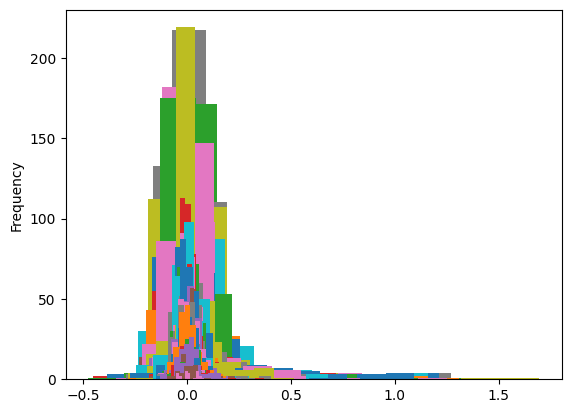

In [ ]:
# can plot average response based on stimulus presentation in the session ... (I wonder what exp this is.. )
average_responses.groupby('fam_score')['dff'].plot(kind='hist')



Now we can construct a dataframe called `features_and_labels` that will contain one row per trial, one column per cell, plus columns with the image_index and image_name

In [ ]:
features_and_labels = average_responses.pivot(
    index='stimulus_presentations_id',
    columns='cell_specimen_id',
    values='dff'
).join(
    average_responses[['fam_score']],
    on= 'stimulus_presentations_id',
    how='left'
)
features_and_labels.sample(10)

1086611670  1086612075  1086612670  1086612827  \
stimulus_presentations_id                                                   
1011                         0.072948    0.004138    0.005799    0.000532   
2063                         0.030494   -0.074481   -0.010662    0.029076   
3982                        -0.048797   -0.003469   -0.006227   -0.025191   
113                         -0.019703    0.000315    0.034644   -0.016326   
1098                        -0.000846   -0.054063    0.014449   -0.018583   
1692                         0.008847    0.013343   -0.009873    0.011464   
3368                         0.012262    0.101544    0.023338    0.020224   
311                          0.043596    0.035652    0.034531    0.006583   
3961                         0.017268    0.012896   -0.012050    0.082380   
1115                         0.041221    0.064212    0.030203   -0.017772   

                           1086617208  1086617362  1086617474  1086618511  \
stimulus_presentations_id                                                   
1011                         0.053469   -0.008366    0.062104   -0.015788   
2063                         0.053169    0.050611    0.059611    0.081959   
3982                        -0.024812    0.026163    0.064155   -0.070660   
113                          0.054739    0.012042    0.064234   -0.021668   
1098                         0.051622    0.033205   -0.035103    0.050441   
1692                         0.027050   -0.019133    0.100464    0.046040   
3368                         0.010699   -0.005093    0.051155   -0.038087   
311                          0.117960    0.081366    0.048180   -0.011858   
3961                        -0.091970    0.045522    0.017555    0.126108   
1115                         0.036429    0.075010   -0.077067    0.047213   

                           1086618912  1086619247  1086620047  1086621003  \
stimulus_presentations_id                                                   
1011                         0.041873   -0.026764   -0.019080    0.029334   
2063                        -0.037259   -0.016430   -0.024199    0.042023   
3982                         0.324518    0.015368    0.050594   -0.087965   
113                         -0.033245    0.078855    0.017430    0.037547   
1098                        -0.039470   -0.082233   -0.009493    0.028432   
1692                         0.233321    0.010182    0.010759   -0.006561   
3368                        -0.068482    0.120734    0.020132    0.050719   
311                          0.022658    0.361385   -0.036873    0.008415   
3961                        -0.083870   -0.036402   -0.007771    0.206012   
1115                        -0.020711    0.022045    0.016825   -0.033343   

                           fam_score  
stimulus_presentations_id             
1011                             6.0  
2063                             7.0  
3982                            16.0  
113                              1.0  
1098                             3.0  
1692                             4.0  
3368                            12.0  
311                              2.0  
3961                            15.0  
1115                             3.0

In [ ]:
features_and_labels = average_responses.pivot(
    index='stimulus_presentations_id',
    columns='cell_specimen_id',
    values='dff'
).merge(
    stimulus_table[['image_index','image_name']],
    on='stimulus_presentations_id',
    how='left'
)
features_and_labels.sample(10)

KeyError: ignored

The X matrix can be extracted by getting the columns associated with the cell_specimen_ids

In [ ]:
X = features_and_labels[cell_ids]
X.sample(10)

1086617208  1086618511  1086617362  1086620047  \
stimulus_presentations_id                                                   
2378                         0.069300    0.017185    0.091330    0.124484   
915                         -0.004561    0.038086   -0.027311    0.027155   
3800                         0.074244    0.043640    0.147263    0.011291   
3964                        -0.042081   -0.076884   -0.049473    0.089029   
2856                         0.036480   -0.024376    0.116309    0.008548   
855                         -0.089322    0.043701   -0.013510    0.006005   
827                          0.078996    0.000670   -0.005639   -0.033812   
3197                         0.006113   -0.052509    0.013907    0.047306   
2250                         0.121787   -0.030333    0.077658    0.038156   
1989                        -0.012837   -0.042166   -0.112679    0.006451   

                           1086618912  1086617474  1086621003  1086619247  \
stimulus_presentations_id                                                   
2378                         0.017285   -0.027491   -0.086955   -0.007714   
915                          0.058924    0.008639   -0.043921    0.012930   
3800                        -0.081391    0.112364   -0.082358    0.000730   
3964                        -0.039187    0.016716   -0.012500    0.019388   
2856                         0.033606   -0.006250    0.063847    0.089447   
855                         -0.091816   -0.016682   -0.084092    0.014026   
827                         -0.022925   -0.019560    0.044710    0.048174   
3197                        -0.035803   -0.043436    0.013607    0.011953   
2250                         0.616877    0.114304    0.041087    0.046092   
1989                         0.010609   -0.042307   -0.047949    0.056422   

                           1086612670  1086612827  1086612075  1086611670  
stimulus_presentations_id                                                  
2378                         0.030820    0.069638    0.075591    0.003247  
915                          0.047139   -0.013031   -0.008988    0.062365  
3800                        -0.015400    0.007357   -0.063382   -0.012951  
3964                         0.013406    0.010255   -0.082499    0.029623  
2856                         0.046687    0.049974    0.001412    0.033808  
855                         -0.021688    0.022433    0.003851   -0.035172  
827                          0.024612    0.013736   -0.046346    0.006899  
3197                         0.014789   -0.033318    0.008834   -0.006369  
2250                         0.026252    0.004557   -0.018219    0.007883  
1989                         0.034774    0.003904   -0.000505    0.002979

And `y` is just the `image_name` column (it could also be the `image_index` column if you want a numeric value instead of a string to represent the image identity)

In [ ]:
y = features_and_labels['fam_score']
y.sample(10)

stimulus_presentations_id
4806    23.0
4682    22.0
3726    12.0
1639     5.0
2850     8.0
3776    13.0
4385    21.0
1416     3.0
3578    11.0
1991     5.0
Name: fam_score, dtype: float64

## Dimensionality reduction
Now we can use t-SNE, which will project our 53-dimensional feature space (53 neurons in the session) into two dimensions.

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X.values)

And visualize the results, with colors representing each unique stimulus.

<ipython-input-123-230fcbc42aca>:4: UserWarning: 
The palette list has fewer values (9) than needed (23) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(


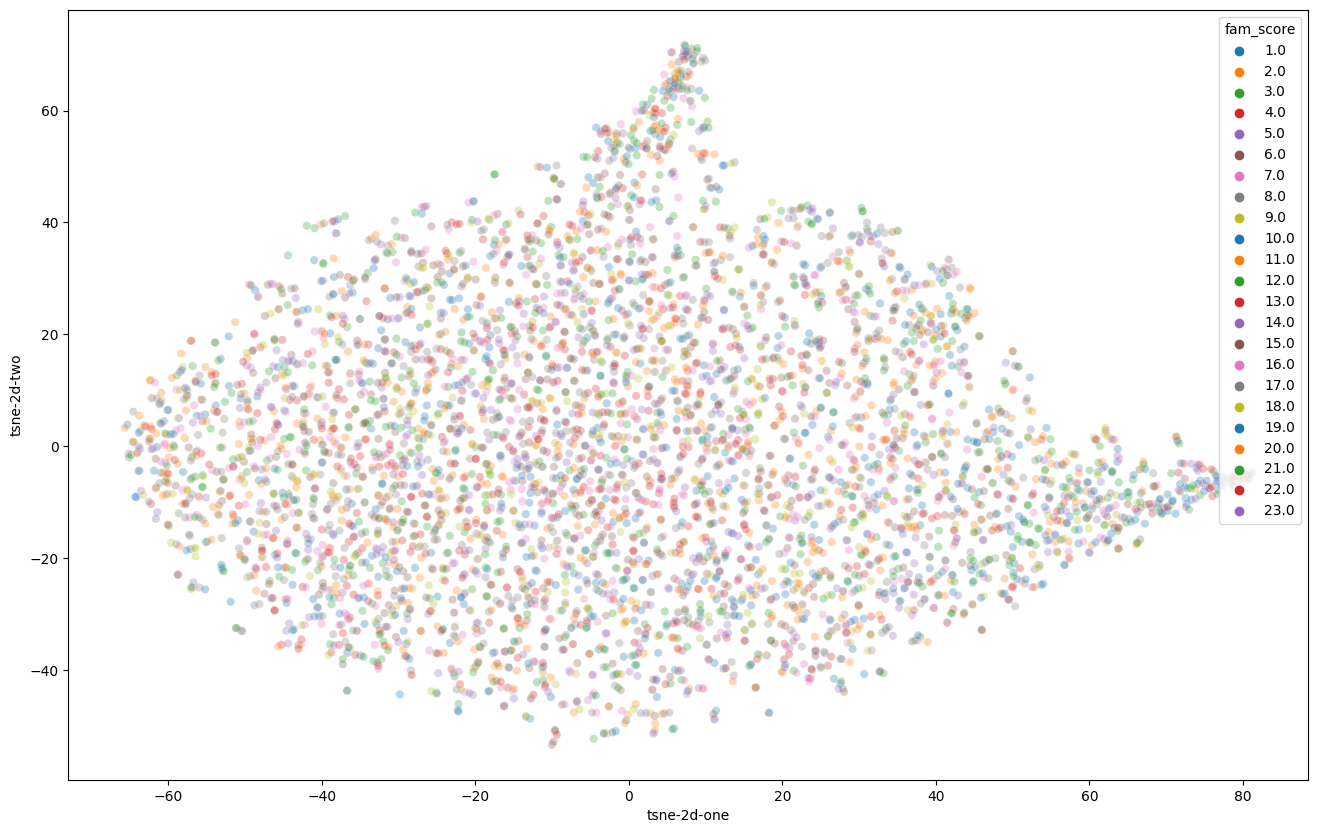

In [ ]:
features_and_labels['tsne-2d-one'] = X_embedded[:, 0]
features_and_labels['tsne-2d-two'] = X_embedded[:, 1]
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(
    data=features_and_labels,
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="fam_score", # image_name
    hue_order=np.sort(features_and_labels['fam_score'].unique()), # image_name
    palette=sns.color_palette()[:9],
    legend="full",
    alpha=0.3
)

This demonstrates that the time-averaged population responses to at least some of the stimuli seem to fall into distinct clusters in our 53-dimensional space, while others appear more overlapped. This implies that a decoding analysis might be more successful at decoding some stimuli than others.

## Train a simple decoder
We can use an SVM decoder from scikit learn to ask how well we can decode image identity from the feature matrix we have constructed.

Split our data into train and test sets, instantiate the model, then fit.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = svm.SVC(probability=True)
model.fit(X_train, y_train)

SVC(probability=True)

Use the model to make predictions on the held-out test set

In [ ]:
y_pred = model.predict(X_test)

Evaluate the accuracy

In [ ]:
accuracy_score(y_test, y_pred)

0.619798234552333

Evaluate the confusion matrix

In [ ]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['predicted_{}'.format(im) for im in model.classes_],
    index=['actual_{}'.format(im) for im in model.classes_]
)

predicted_im000  predicted_im031  predicted_im035  \
actual_im000                 87                4               55   
actual_im031                 13               84               36   
actual_im035                  4               17              125   
actual_im045                  0               16                7   
actual_im054                 35                7               26   
actual_im073                  5               15               43   
actual_im075                  3                8               22   
actual_im106                  0                3               10   
actual_omitted                7                8               12   

                predicted_im045  predicted_im054  predicted_im073  \
actual_im000                  1               20               30   
actual_im031                  0                9               37   
actual_im035                  0                7               23   
actual_im045                163                1               13   
actual_im054                  0               90               27   
actual_im073                  0                5              107   
actual_im075                  0                2               33   
actual_im106                  0                1               11   
actual_omitted                1                6                7   

                predicted_im075  predicted_im106  predicted_omitted  
actual_im000                  0                0                  0  
actual_im031                  0                1                  2  
actual_im035                  0                2                  0  
actual_im045                  1                0                  0  
actual_im054                  0                0                  1  
actual_im073                  0                1                  0  
actual_im075                124                2                  0  
actual_im106                  1              193                  0  
actual_omitted                1                1                 10

This tells us that the model can decode some stimuli well (im035, im075 and im106, for example), while it struggles more with others (im000 and omissions, for example). Do the stimuli that the decoder succeeds in classifying align with those that cluster cleanly in t-SNE space?

### Follow up exercise

Can you create event triggered averages and perform decoding using other events of interest, such as licks or rewards?

In [ ]:
# Lick and reward data are available for each experiment
licks = experiments[ophys_experiment_id].licks
licks.head()

timestamps  frame
0    68.90307   3499
1    77.14313   3993
2    84.09879   4410
3    85.31647   4483
4    94.64071   5042

In [ ]:
rewards = experiments[ophys_experiment_id].rewards
rewards.head()

volume  timestamps  auto_rewarded
0   0.005   318.95740           True
1   0.005   328.69873           True
2   0.005   337.73943           True
3   0.005   354.25289           True
4   0.005   364.74479           True

To see the full list of all attributes available for each experiment via the AllenSDK, uncomment the cell below and run it

In [ ]:
help(experiments[ophys_experiment_id])